# Validation of DINOv3 (intensive validation)
#### at field transects along ICESat-2/ATLAS transects at Seward sites)

with field observations at ground level (TODO) and from UAV 

https://docs.google.com/spreadsheets/d/1jqP0K0LZmswK4ZZNU6BxKYgjaBZM0HRkUrWS1QFLvIE/edit?gid=0#gid=0  

could be used for manuscript:
https://docs.google.com/document/d/1uj9-xlLTJK1xeGvzIEHvNNnquXYMUNsBDB30a3HhlOc/edit?usp=sharing

| Author | Affiliation | Date |
| --- | --- | --- |
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Sept. 2024 |

In [20]:
import os
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
import fiona
import numpy as np
from basemaplib import *

In [21]:
import plotnine
from plotnine import *

### CHM model training chips

In [22]:
# chips_df_ifsar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
# chips_df_lidar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')

In [23]:
class_name_list =  list(reversed(['Noise','Ground','Canopy','Top of canopy'][1:]))
class_color_list = list(reversed(['lightgrey','brown','lightgreen','darkgreen'][1:]))
PLOT_CONFIG = None

In [24]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'
OUTDIR_PLOTS = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots'

### UAV data footprints

In [25]:
footprint_uav_gdf = gpd.read_file(f'{OUTDIR}/footprints_uav_sewardpen2024_RGB_COG.gpkg')

## Read tables: Raster CHM extractions at field points

In [26]:
# Read seward reference data frame
all_ref_m = pd.read_csv(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation.csv'))
all_ref_m.shape
#all_ref_gdf_extract = gpd.read_file(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation_unmelted.gpkg'))

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_2954846/635288899.py:2: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.


(1586060, 19)

In [27]:
# all_ref_m['source_cat'] = all_ref_m['source_cat'].replace('Deep Learning', 'AI Prediction')
# all_ref_m.source_cat.unique()

In [28]:
# all_ref_m['source_type'] = all_ref_m['source_type'].replace('VHR CHM v4.3.2.2 (DINOv3)', 'CHM (DINOv3)')
# all_ref_m.source_type.unique()

In [29]:

all_ref_m.head()

,Unnamed: 0,height_ref,site,type_ref,class_name,color,beam,doy,x,y,source,value,source_cat,source_mod_dev_app_class,source_type,source_extent,source_res,source_temp,source_temp_dif_ref
0,0,0.091385,council_01,ATL03,Ground,brown,gt1l,230.0,-1.584183e+07,6.632302e+06,ht_uavchm030,1.726852,Observation,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif
1,1,0.095764,council_01,ATL03,Ground,brown,gt1l,230.0,-1.584183e+07,6.632302e+06,ht_uavchm030,1.726852,Observation,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif
2,2,-0.077309,council_01,ATL03,Ground,brown,gt1l,230.0,-1.584183e+07,6.632304e+06,ht_uavchm030,2.198723,Observation,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif
3,3,-0.090279,council_01,ATL03,Ground,brown,gt1l,230.0,-1.584183e+07,6.632304e+06,ht_uavchm030,2.198723,Observation,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif
4,4,-0.021507,council_01,ATL03,Ground,brown,gt1l,230.0,-1.584183e+07,6.632304e+06,ht_uavchm030,2.198723,Observation,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif


## Exploratory plotting

In [30]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy import stats
from scipy import stats as sp_stats
from sklearn import metrics

In [31]:
# =============================================================================
# MODEL ATTRIBUTE MAPPINGS
# =============================================================================

MODEL_ATTRIBUTES = {
    'VHR CHM v1.0 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v1.5.1 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v1.5.2 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.1 (ViT DINOv2)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.1 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.2 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.3 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.4 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v3.3.2.1 (DINOv3)': {
        'loss_function': 'MSE',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v3.3.2.2 (DINOv3)': {
        'loss_function': 'custom',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v3.3.2.3 (DINOv3)': {
        'loss_function': 'MSE',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v3.3.2.4 (DINOv3)': {
        'loss_function': 'MAE',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v4.3.2.2 (DINOv3)': { # this is the same as 4.3.2.5 - this dir was where ALL the strips where put once we batched processed the 4.3.2.2 model..confusing, i know.
    #'CHM (DINOv3)': { # adjusting this label for final plot for manuscript
        'loss_function': 'custom',
        'training_size': 'Full (400K)',
        'model_family': 'Deep Learning', #'AI prediction', #
        'is_model': True,
    },
    'VHR CHM v4.3.2.3 (DINOv3)': {
        'loss_function': 'MSE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v4.3.2.4 (DINOv3)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    # Observations - reference data
    'CHM (training; airborne IFSAR)': {
        'loss_function': 'N/A',
        'training_size': 'N/A',
        'model_family': 'Observation',
        'is_model': False,
    },
    'CHM (ref.; UAV)': {
        'loss_function': 'N/A',
        'training_size': 'N/A',
        'model_family': 'Observation',
        'is_model': False,
    },
    'UAV': {
        'loss_function': 'N/A',
        'training_size': 'N/A',
        'model_family': 'Observation',
        'is_model': False,
    },
    # Machine Learning models
    'NASA|UMd HLS': {
        'loss_function': 'N/A',
        'training_size': 'N/A',
        'model_family': 'Machine Learning',
        'is_model': True,
    },
    'NASA|UMd S1+HLS': {
        'loss_function': 'N/A',
        'training_size': 'N/A',
        'model_family': 'Machine Learning',
        'is_model': True,
    },
    # Published models
    'Pub: Lang et al. 2023': {
        'loss_function': 'Unknown',
        'training_size': 'Unknown',
        'model_family': 'Deep Learning', #'AI prediction', #
        'is_model': True,
    },
    'Pub: Potapov et al. 2021': {
        'loss_function': 'Unknown',
        'training_size': 'Unknown',
        'model_family': 'Machine Learning',
        'is_model': True,
    },
    'Pub: Tolan et al. 2024': {
        'loss_function': 'Unknown',
        'training_size': 'Unknown',
        'model_family': 'Machine Learning',
        'is_model': True,
    },
}

In [32]:


# Default values for models not in the mapping
# DEFAULT_ATTRIBUTES = {
#     'loss_function': 'Unknown',
#     'training_size': 'Unknown',
# }

# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def prepare_dataframe(all_ref_m):
    """Clean and prepare the dataframe for analysis."""
    
    # Set categorical ordering
    all_ref_m['source_extent'] = pd.Categorical(
        all_ref_m['source_extent'], 
        categories=['Global', 'Circumpolar', 'Regional', 'Local']
    )
    all_ref_m['source_cat'] = pd.Categorical(
        all_ref_m['source_cat'], 
        categories=['Observation', 'Machine Learning', 'Deep Learning'] #'AI prediction'] #
    )
    
    # Filter data
    df = all_ref_m[
        (all_ref_m.value != -9999) & 
        (all_ref_m.value != 255) &
        (
            (all_ref_m.type_ref == 'field 2m') | 
            (all_ref_m.type_ref == 'field 0.3m')
        ) #&
        # ~((all_ref_m.source_type == 'VHR CHM v1.0 (UNet)') & 
        #   (all_ref_m.source_res == '10m'))
    ].copy()
    
    # Parse source column
    df.rename(columns=lambda x: x.split('chm_')[0], inplace=True)
    df[['source_simple', 'source_extra1']] = df['source'].str.split('chm_', n=1, expand=True)
    df[['source_simple', 'source_extra2']] = df['source_simple'].str.split('cnn', n=1, expand=True)
    df[['source_extra3', 'source_simple']] = df['source_simple'].str.split('ht_', n=1, expand=True)
    
    # Add model attributes
    df = add_model_attributes(df)
    
    return df

def apply_scaling(df, scale_config):
    """Apply scaling to specific model predictions."""
    active_patterns = [p for p, enabled in scale_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        mask = df['source_type'].str.contains(pattern, case=True, na=False)
        df.loc[mask, 'value'] = df.loc[mask, 'value'] / 10
    return df

def filter_models(df, include_config):
    """Filter dataframe to include only specified models."""
    active_patterns = [p for p, enabled in include_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        df = df[df['source_type'].str.contains(pattern, case=True, na=False)]
    return df

def apply_filters(df, filter_config):
    """Apply additional data filters."""
    df = df[df['type_ref'].isin(filter_config['reference_types'])]
    df = df[~df['source_res'].isin(filter_config['exclude_resolutions'])]
    df = df[~df['source_type'].isin(filter_config['exclude_types'])]
    return df

# =============================================================================
# STATISTICAL FUNCTIONS
# =============================================================================

def format_stats_labels(stats_df):
    """Create formatted label strings for plot annotations."""
    # Filter out rows with NaN values first
    stats_df = stats_df.dropna(subset=['r2', 'rmse', 'mae', 'bias', 'n'])
    
    stats_df['label_r2'] = stats_df['r2'].apply(lambda x: f"$R^2$ = {x:.2f}")
    stats_df['label_rmse'] = stats_df['rmse'].apply(lambda x: f"RMSE = {x:.2f} m")
    stats_df['label_mae'] = stats_df['mae'].apply(lambda x: f"MAE = {x:.2f} m")
    stats_df['label_bias'] = stats_df['bias'].apply(lambda x: f"Bias = {x:.2f} m")
    stats_df['label_n'] = stats_df['n'].apply(lambda x: f"n = {round(x, 0):,}")
    
    # Create a combined stats label
    stats_df['combined_stats'] = (
        stats_df['label_n'] + '\n' +
        stats_df['label_r2'] + '\n' +
        stats_df['label_rmse'] + '\n' +
        stats_df['label_mae'] + '\n' +
        stats_df['label_bias']
    )
    
    return stats_df

def create_facet_label(df, facet_vars):
    """Create a combined facet label from multiple variables."""
    label_parts = []
    for var in facet_vars:
        if var in df.columns:
            label_parts.append(df[var].astype(str))
    
    if label_parts:
        df['facet_label'] = label_parts[0]
        for part in label_parts[1:]:
            df['facet_label'] = df['facet_label'] + '\n' + part
    else:
        df['facet_label'] = 'All Data'
    
    return df

# =============================================================================
# PLOTTING FUNCTIONS
# =============================================================================

def create_validation_plot_wrap(df, group_vars, facet_vars, config=PLOT_CONFIG):
    """Create validation plot using facet_wrap for better handling of long labels."""
    
    # Create combined facet label
    df = create_facet_label(df, facet_vars)
    group_vars_with_facet = group_vars + ['facet_label']
    
    # Calculate statistics
    summary_df = (
        df.groupby(group_vars_with_facet)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    
    # Filter out any rows with insufficient data
    summary_df = summary_df[summary_df['n'] >= 10].copy()
    summary_df = format_stats_labels(summary_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Create plot
    p = (
        ggplot(df, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Add background rectangle for stats text
        + geom_rect(
            data=summary_df,
            mapping=aes(xmin=0, xmax=max_val*0.45, ymin=max_val*0.60, ymax=max_val),
            fill='white', alpha=0.85, inherit_aes=False
        )
        
        # Single combined label
        + geom_label(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.82, label='combined_stats'),
            ha='left', va='center', size=lab_sz, 
            label_padding=0.25, label_size=0,
            fill='white', alpha=0.9,
            inherit_aes=False
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Vegetation height from field observation (m)', 
            y='Vegetation height from remote sensing (m)',
            title='Intensive validation of vegetation height\nSeward Peninsula, Alaska'
        )
        + facet_wrap('~facet_label', ncol=config['facet_ncol'], labeller='label_value')
        + theme_bw()
        + theme(
            figure_size=config['figure_size'],
            strip_text=element_text(size=10
                                    #, face='bold'
                                    , margin={'t': 5, 'b': 5}),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=11),
            axis_title=element_text(size=12
                                    #, face='bold'
                                   ),
            plot_title=element_text(size=14
                                    #, face='bold'
                                   ),
            legend_position='right',
            panel_spacing=0.3,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, summary_df

def create_validation_plot_grid(df, group_vars, facet_row_vars, facet_col_vars, config=PLOT_CONFIG):
    """Create validation plot using facet_grid for structured 2D layouts."""
    
    # Build facet formula
    row_formula = ' + '.join(facet_row_vars) if facet_row_vars else '.'
    col_formula = ' + '.join(facet_col_vars) if facet_col_vars else '.'
    facet_formula = f'{row_formula} ~ {col_formula}'
    
    # Combine all grouping variables and remove duplicates
    all_group_vars = list(set(group_vars + facet_row_vars + facet_col_vars))
    
    # Make a copy and drop rows with NaN in grouping variables
    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=all_group_vars)
    
    print(f"Rows after dropping NaN in grouping vars: {len(df_plot)}")
    
    # Calculate statistics with proper grouping
    summary_df = (
        df_plot.groupby(all_group_vars, observed=True)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    
    # Filter and format
    summary_df = summary_df[summary_df['n'] >= 10].copy()
    summary_df = format_stats_labels(summary_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Adjust figure size for grid layout
    config_grid = config.copy()
    # Calculate number of unique values for sizing
    if facet_row_vars:
        row_df = df_plot[facet_row_vars].drop_duplicates()
        n_rows = len(row_df)
    else:
        n_rows = 1
    
    if facet_col_vars:
        col_df = df_plot[facet_col_vars].drop_duplicates()
        n_cols = len(col_df)
    else:
        n_cols = 1
        
    config_grid['figure_size'] = (6 * n_cols, 5 * n_rows)
    
    # Create plot
    p = (
        ggplot(df_plot, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Add background rectangle for stats text
        + geom_rect(
            data=summary_df,
            mapping=aes(xmin=0, xmax=max_val*0.45, ymin=max_val*0.60, ymax=max_val),
            fill='white', alpha=0.85, inherit_aes=False
        )
        
        # Single combined label
        + geom_label(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.82, label='combined_stats'),
            ha='left', va='center', size=lab_sz+4, 
            label_padding=0.25, label_size=0,
            fill='white', alpha=0.9,
            inherit_aes=False
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Vegetation height from field observation (m)', 
            y='Vegetation height from remote sensing (m)',
            title='Intensive validation of vegetation height\nSeward Peninsula, Alaska'
        )
        + facet_grid(facet_formula, labeller='label_both')
        + theme_bw()
        + theme(
            figure_size=config_grid['figure_size'],
            strip_text_x=element_text(size=11, face='bold'),
            strip_text_y=element_text(size=11, face='bold'),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=12),
            axis_title=element_text(size=11, face='bold'),
            plot_title=element_text(size=13, face='bold'),
            legend_position='right',
            panel_spacing=0.2,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, summary_df

In [33]:
# =============================================================================
# MODEL ATTRIBUTE MAPPINGS - Include ALL source types
# =============================================================================


# Default values for any unmapped sources
DEFAULT_ATTRIBUTES = {
    'loss_function': 'Unknown',
    'training_size': 'Unknown',
    'model_family': 'Other',
    'is_model': True,
}

In [34]:
# =============================================================================
# UPDATED add_model_attributes function
# =============================================================================

def add_model_attributes(df, attribute_mapping=MODEL_ATTRIBUTES, default_attrs=DEFAULT_ATTRIBUTES):
    """Add loss_function, training_size, and other attributes based on source_type."""
    
    # Initialize with default values
    for attr, default_value in default_attrs.items():
        df[attr] = default_value
    
    # Map attributes for each model
    for source_type, attributes in attribute_mapping.items():
        mask = df['source_type'] == source_type
        for attr, value in attributes.items():
            df.loc[mask, attr] = value
    
    # Set categorical ordering for better plot organization
    df['loss_function'] = pd.Categorical(
        df['loss_function'],
        categories=['MAE', 'MSE', 'custom'],
        ordered=True
    )
    
    df['training_size'] = pd.Categorical(
        df['training_size'],
        categories=['Medium (50K)', 'Large (100K)', 'Full (400K)'],
        ordered=True
    )
    
    df['model_family'] = pd.Categorical(
        df['model_family'],
        categories=['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other'],
        ordered=True
    )
    
    return df

In [35]:
def calculate_validation_stats(group, ref_col='height_ref', pred_col='value'):
    """Calculate comprehensive validation statistics with robust error handling."""
    
    # Get initial count
    n_initial = len(group)
    
    # Extract columns
    ref = group[ref_col]
    pred = group[pred_col]
    
    # Drop NaN values from both columns
    valid_mask = ref.notna() & pred.notna()
    ref = ref[valid_mask]
    pred = pred[valid_mask]
    
    n = len(ref)
    
    # Check if we have enough valid data
    if n < 2:
        if n_initial > 0:
            print(f"Warning: Group had {n_initial} rows but only {n} valid pairs after removing NaN")
        return pd.Series({
            'n': n,
            'slope': np.nan,
            'intercept': np.nan,
            'r_value': np.nan,
            'r2': np.nan,
            'p_value': np.nan,
            'std_err': np.nan,
            'rmse': np.nan,
            'mae': np.nan,
            'medae': np.nan,
            'mse': np.nan,
            'exp_var': np.nan,
            'bias': np.nan,
        })
    
    # Check for infinite values
    if not (np.isfinite(ref).all() and np.isfinite(pred).all()):
        print(f"Warning: Infinite values found in group")
        return pd.Series({
            'n': n,
            'slope': np.nan,
            'intercept': np.nan,
            'r_value': np.nan,
            'r2': np.nan,
            'p_value': np.nan,
            'std_err': np.nan,
            'rmse': np.nan,
            'mae': np.nan,
            'medae': np.nan,
            'mse': np.nan,
            'exp_var': np.nan,
            'bias': np.nan,
        })
    
    # Check for constant values (no variance)
    if ref.std() == 0 or pred.std() == 0:
        # Can still calculate some metrics
        return pd.Series({
            'n': n,
            'slope': np.nan,
            'intercept': np.nan,
            'r_value': np.nan,
            'r2': np.nan,
            'p_value': np.nan,
            'std_err': np.nan,
            'rmse': np.sqrt(metrics.mean_squared_error(ref, pred)),
            'mae': metrics.mean_absolute_error(ref, pred),
            'medae': metrics.median_absolute_error(ref, pred),
            'mse': metrics.mean_squared_error(ref, pred),
            'exp_var': np.nan,
            'bias': np.mean(pred - ref),
        })
    
    try:
        # Linear regression
        slope, intercept, r_value, p_value, std_err = sp_stats.linregress(ref, pred)
        
        # Performance metrics
        stats_dict = {
            'n': n,
            'slope': slope,
            'intercept': intercept,
            'r_value': r_value,
            'r2': r_value ** 2,
            'p_value': p_value,
            'std_err': std_err,
            'rmse': np.sqrt(metrics.mean_squared_error(ref, pred)),
            'mae': metrics.mean_absolute_error(ref, pred),
            'medae': metrics.median_absolute_error(ref, pred),
            'mse': metrics.mean_squared_error(ref, pred),
            'exp_var': metrics.explained_variance_score(ref, pred),
            'bias': np.mean(pred - ref),
        }
        
        return pd.Series(stats_dict)
        
    except Exception as e:
        print(f"Error calculating stats: {e}")
        print(f"Group size: {n}")
        print(f"Ref - min: {ref.min():.2f}, max: {ref.max():.2f}, mean: {ref.mean():.2f}")
        print(f"Pred - min: {pred.min():.2f}, max: {pred.max():.2f}, mean: {pred.mean():.2f}")
        print(f"NaN in ref: {ref.isna().sum()}, NaN in pred: {pred.isna().sum()}")
        raise

In [36]:
def run_validation_analysis(
    all_ref_m, PLOT_CONFIG, FILTER_CONFIG,
    output_dir=None, 
    plot_type='wrap',
    facet_row_vars=None,
    facet_col_vars=None,
    facet_wrap_vars=None,
    include_observations=True,
    filter_by_attribute=None
):
    """
    Main function to run the complete validation analysis.
    """
    
    # Prepare data
    print("Preparing dataframe...")
    df = prepare_dataframe(all_ref_m)
    df = apply_scaling(df, FILTER_CONFIG['scale_by_10'])
    df = filter_models(df, FILTER_CONFIG['include_models'])
    df = apply_filters(df, FILTER_CONFIG)
    
    print(f"Initial filtered data shape: {df.shape}")
    
    # Filter by observations if needed
    if not include_observations:
        df = df[df['is_model'] == True]
        print(f"After removing observations: {df.shape}")
    
    # Apply custom attribute filters
    if filter_by_attribute:
        for attr, values in filter_by_attribute.items():
            if attr in df.columns:
                df = df[df[attr].isin(values)]
                print(f"After filtering {attr} to {values}: {df.shape}")
    
    # Smart filtering for faceting
    if plot_type == 'grid' and (facet_row_vars or facet_col_vars):
        all_facet_vars = (facet_row_vars or []) + (facet_col_vars or [])
        model_specific_vars = ['loss_function', 'training_size', 'model_family']
        
        if any(var in model_specific_vars for var in all_facet_vars):
            if not include_observations:
                for var in model_specific_vars:
                    if var in all_facet_vars and var in df.columns:
                        df = df[df[var] != 'N/A']
                        print(f"Filtered out N/A in {var}: {len(df)} rows remain")
    
    print(f"Final filtered data shape: {df.shape}")
    print(f"Unique models: {df['source_type'].unique()}")
    
    if len(df) == 0:
        print("ERROR: No data remaining after filtering!")
        return None, None
    
    # Fixed: Use list() instead of sorted() for categorical columns
    print(f"\nAvailable attributes for faceting:")
    print(f"  - loss_function: {list(df['loss_function'].cat.categories)}")
    print(f"  - training_size: {list(df['training_size'].cat.categories)}")
    print(f"  - model_family: {list(df['model_family'].cat.categories)}")
    print(f"  - is_model: {df['is_model'].unique().tolist()}")
    
    # Show actual values present in filtered data
    print(f"\nActual values in filtered data:")
    print(f"  - loss_function: {df['loss_function'].unique().tolist()}")
    print(f"  - training_size: {df['training_size'].unique().tolist()}")
    print(f"  - model_family: {df['model_family'].unique().tolist()}")
    
    # Set plot configuration
    plotnine.options.figure_size = PLOT_CONFIG['figure_size']
    
    # Define base grouping variables
    group_vars = ['type_ref', 'source_extent', 'source_cat']
    
    # Create plot based on type
    print(f"\nCreating {plot_type} plot...")
    
    if plot_type == 'grid':
        if facet_row_vars is None:
            facet_row_vars = []
        if facet_col_vars is None:
            facet_col_vars = ['source_type']
        
        plot, stats = create_validation_plot_grid(
            df,
            group_vars=group_vars,
            facet_row_vars=facet_row_vars,
            facet_col_vars=facet_col_vars,
            config=PLOT_CONFIG
        )
    else:  # wrap
        if facet_wrap_vars is None:
            facet_wrap_vars = ['source_cat', 'source_type']
        
        plot, stats = create_validation_plot_wrap(
            df,
            group_vars=group_vars,
            facet_vars=facet_wrap_vars,
            config=PLOT_CONFIG
        )
    
    # Display statistics summary
    print("\n=== Validation Statistics Summary ===")
    display_cols = ['source_type', 'n', 'r2', 'rmse', 'mae', 'bias']
    if 'loss_function' in stats.columns:
        display_cols.insert(1, 'loss_function')
    if 'training_size' in stats.columns:
        display_cols.insert(2, 'training_size')
    if 'model_family' in stats.columns:
        display_cols.insert(1, 'model_family')
    
    available_cols = [col for col in display_cols if col in stats.columns]
    print(stats[available_cols].to_string(index=False))
    
    # Save plot if output directory provided
    if output_dir:
        import os
        suffix = '_with_obs' if include_observations else '_models_only'
        filename = os.path.join(output_dir, f'validation_plot_{plot_type}{suffix}.png')
        plot.save(filename=filename, dpi=PLOT_CONFIG['dpi'], verbose=False)
        print(f"\nPlot saved to: {filename}")
        
        # Save statistics
        stats_file = os.path.join(output_dir, f'validation_statistics_{plot_type}{suffix}.csv')
        stats.to_csv(stats_file, index=False)
        print(f"Statistics saved to: {stats_file}")
    
    return plot, stats

## Plot Observations from IFSAR and UAV vs field (context)

In [37]:
PLOT_CONFIG = {
    'figure_size': (12, 12),  # Adjusted for wrap layout
    'max_height': 6,
    'binwidth': 0.25,
    'label_size': 12,
    'dpi': 300,
    'color_scheme': 'plasma',  # or 'plasma', 'inferno', 'magma'
    'facet_ncol': 3,  # Number of columns in facet_wrap
}
FILTER_CONFIG = {
    'include_models': {
        'IFSAR': True, 'UAV': True,
        'UNet': False,
        'DINOv2': False,
        'DINOv3': False,
       # '.3.2.1': False, '.3.2.2': True, '.3.2.3': True, '.3.2.4': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'CHM v2.2.4': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': ['UAV'],
}

Preparing dataframe...
Initial filtered data shape: (2280, 27)
Final filtered data shape: (2280, 27)
Unique models: ['CHM (ref.; UAV)' 'CHM (training; IFSAR)']

Available attributes for faceting:
  - loss_function: ['MAE', 'MSE', 'custom']
  - training_size: ['Medium (50K)', 'Large (100K)', 'Full (400K)']
  - model_family: ['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other']
  - is_model: [False, True]

Actual values in filtered data:
  - loss_function: [nan]
  - training_size: [nan]
  - model_family: ['Observation', 'Other']

Creating grid plot...
Rows after dropping NaN in grouping vars: 2280

=== Validation Statistics Summary ===
          source_type model_family      n    r2  rmse   mae   bias
      CHM (ref.; UAV)  Observation 1138.0 0.664 1.039 0.833 -0.816
CHM (training; IFSAR)        Other 1138.0 0.365 1.513 1.229 -1.225


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 4 rows containing non-finite values.


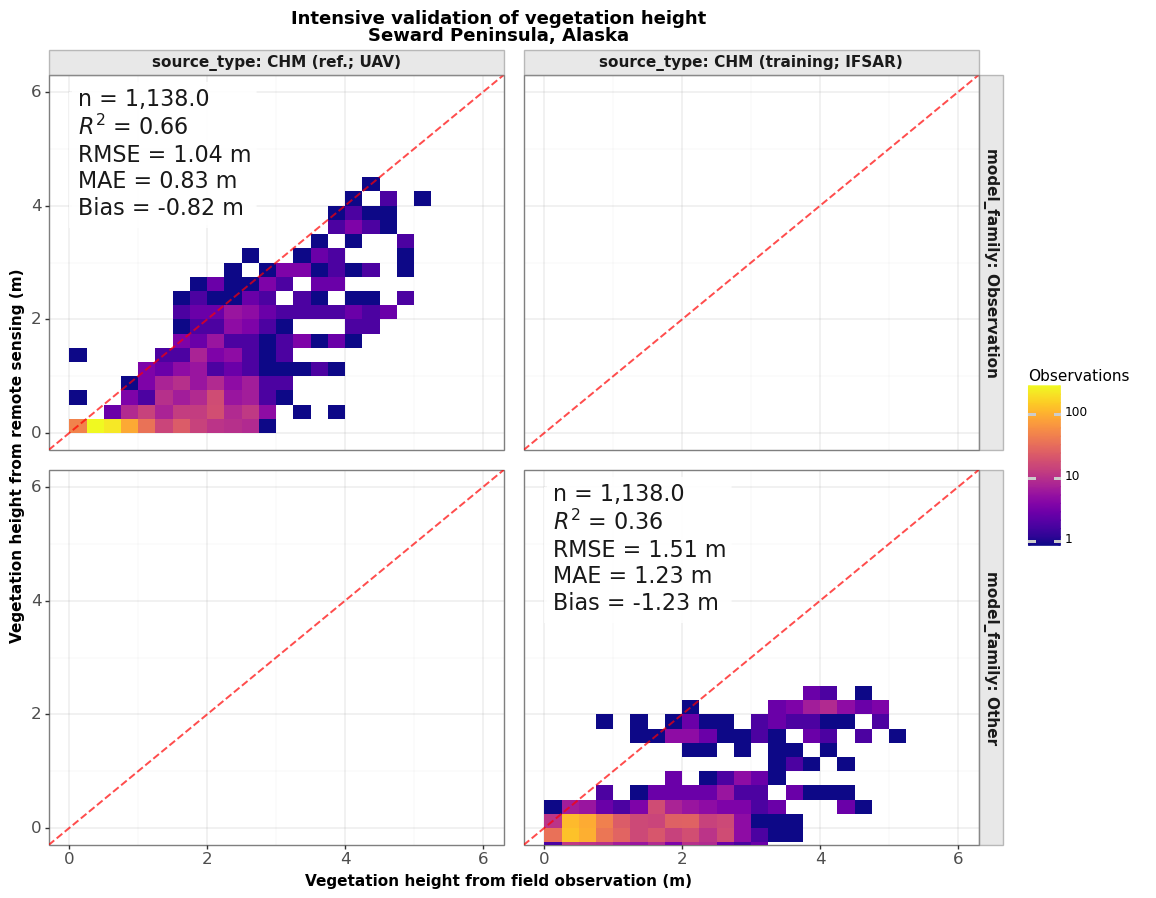

In [38]:
# Example 2: Everything including observations, faceted by model family
plot, stats = run_validation_analysis(
    all_ref_m, PLOT_CONFIG, FILTER_CONFIG,
    plot_type='grid',
    facet_row_vars=['model_family'],
    facet_col_vars=['source_type'],
    include_observations=True  # Include observations
)
print(plot)

In [39]:
PLOT_CONFIG = {
    'figure_size': (12, 4),  # Adjusted for wrap layout
    'max_height': 6,
    'binwidth': 0.25,
    'label_size': 12,
    'dpi': 300,
    'color_scheme': 'plasma',  # or 'plasma', 'inferno', 'magma'
    'facet_ncol': 3,  # Number of columns in facet_wrap
}
FILTER_CONFIG = {
    'include_models': {
        'IFSAR': True, 'UAV': True,
        'UNet': False,
        'DINOv2': False,
        'DINOv3': False,
       #'v4.3.2.2': True,
        'CHM (DINOv3)': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'CHM v2.2.4': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': ['UAV'],
}

Preparing dataframe...


/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_2954846/3045837274.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 4 rows containing non-finite values.


Initial filtered data shape: (2280, 27)
Final filtered data shape: (2280, 27)
Unique models: ['CHM (ref.; UAV)' 'CHM (training; IFSAR)']

Available attributes for faceting:
  - loss_function: ['MAE', 'MSE', 'custom']
  - training_size: ['Medium (50K)', 'Large (100K)', 'Full (400K)']
  - model_family: ['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other']
  - is_model: [False, True]

Actual values in filtered data:
  - loss_function: [nan]
  - training_size: [nan]
  - model_family: ['Observation', 'Other']

Creating wrap plot...

=== Validation Statistics Summary ===
     n    r2  rmse   mae   bias
1138.0 0.664 1.039 0.833 -0.816
1138.0 0.365 1.513 1.229 -1.225


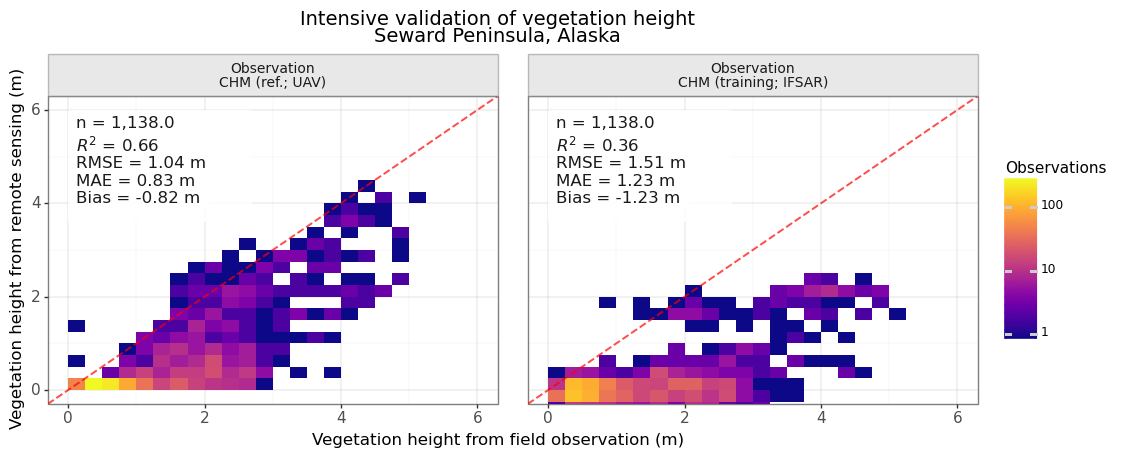

In [40]:
# Standard wrap layout (3 columns)
plot, stats = run_validation_analysis(all_ref_m, PLOT_CONFIG, FILTER_CONFIG, plot_type='wrap',)
print(plot)

Preparing dataframe...


/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_2954846/3045837274.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 4 rows containing non-finite values.


Initial filtered data shape: (2280, 27)
Final filtered data shape: (2280, 27)
Unique models: ['CHM (ref.; UAV)' 'CHM (training; IFSAR)']

Available attributes for faceting:
  - loss_function: ['MAE', 'MSE', 'custom']
  - training_size: ['Medium (50K)', 'Large (100K)', 'Full (400K)']
  - model_family: ['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other']
  - is_model: [False, True]

Actual values in filtered data:
  - loss_function: [nan]
  - training_size: [nan]
  - model_family: ['Observation', 'Other']

Creating wrap plot...

=== Validation Statistics Summary ===
     n    r2  rmse   mae   bias
1138.0 0.664 1.039 0.833 -0.816
1138.0 0.365 1.513 1.229 -1.225


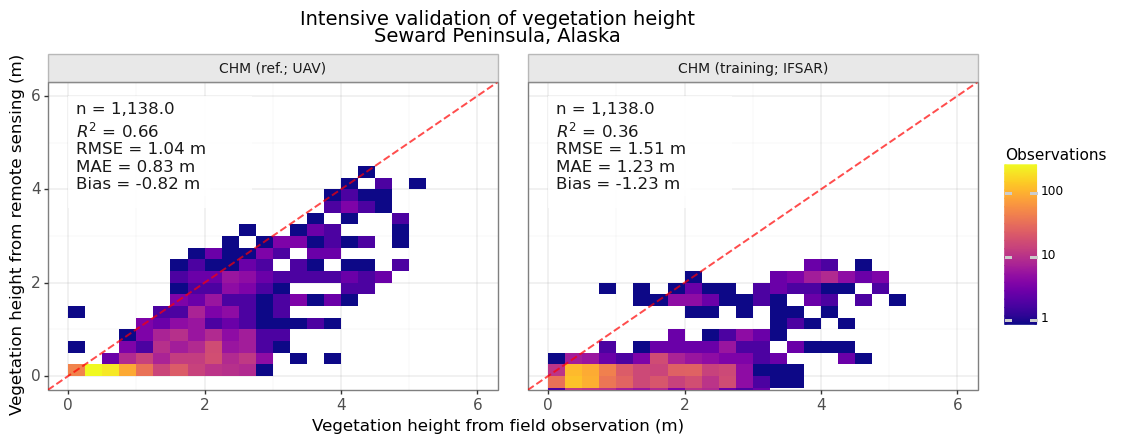

In [41]:
# =============================================================================
# USAGE EXAMPLES
# =============================================================================

# Example 1: facet_wrap with source info
plot, stats = run_validation_analysis(
    all_ref_m, PLOT_CONFIG, FILTER_CONFIG, 
    plot_type='wrap',
    facet_wrap_vars=['source_type']
)
print(plot)

In [23]:
PLOT_CONFIG = {
    'figure_size': (12, 8),  # Adjusted for wrap layout
    'max_height': 6,
    'binwidth': 0.25,
    'label_size': 12,
    'dpi': 300,
    'color_scheme': 'plasma',  # or 'plasma', 'inferno', 'magma'
    'facet_ncol': 3,  # Number of columns in facet_wrap
}

FILTER_CONFIG = {
    'include_models': {
        'UNet': False,
        'DINOv2': False,
        #'DINOv3': True,
        '.3.2.1': False, '.3.2.2': True, '.3.2.3': True, '.3.2.4': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'CHM v2.2.4': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': ['UAV'],
}

Preparing dataframe...
Initial filtered data shape: (8280, 27)
Final filtered data shape: (8280, 27)
Unique models: ['VHR CHM v3.3.2.2 (DINOv3)' 'VHR CHM v3.3.2.3 (DINOv3)'
 'VHR CHM v3.3.2.4 (DINOv3)' 'VHR CHM v4.3.2.3 (DINOv3)']

Available attributes for faceting:
  - loss_function: ['MAE', 'MSE', 'custom']
  - training_size: ['Medium (50K)', 'Large (100K)', 'Full (400K)']
  - model_family: ['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other']
  - is_model: [True]

Actual values in filtered data:
  - loss_function: ['custom', 'MSE', 'MAE']
  - training_size: ['Large (100K)', 'Full (400K)']
  - model_family: ['Other']

Creating grid plot...
Rows after dropping NaN in grouping vars: 8280

=== Validation Statistics Summary ===
loss_function training_size      n    r2  rmse   mae   bias
          MAE  Large (100K) 2070.0 0.582 1.367 1.077 -1.072
          MSE  Large (100K) 2070.0 0.591 1.293 0.996 -0.978
          MSE   Full (400K) 2070.0 0.70

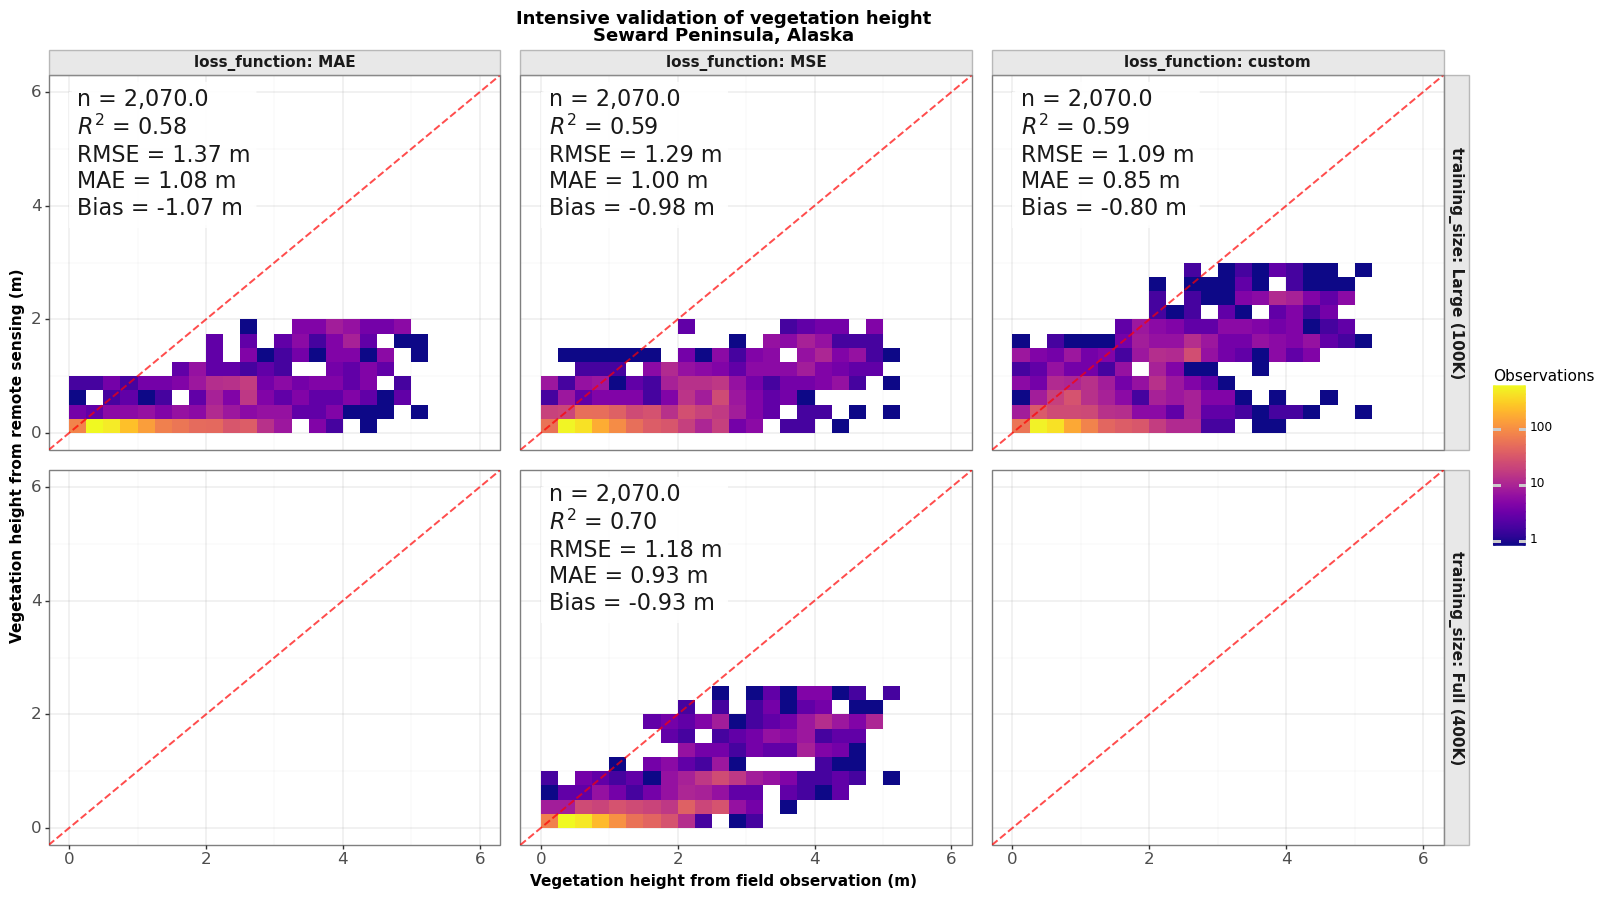

In [24]:
# Example 2: facet_grid with loss function on rows, training size on columns
plot, stats = run_validation_analysis(
    all_ref_m, PLOT_CONFIG, FILTER_CONFIG,
    plot_type='grid',
    facet_row_vars=['training_size'],
    facet_col_vars=['loss_function']
)
print(plot)

Preparing dataframe...
Initial filtered data shape: (8280, 27)
Final filtered data shape: (8280, 27)
Unique models: ['VHR CHM v3.3.2.2 (DINOv3)' 'VHR CHM v3.3.2.3 (DINOv3)'
 'VHR CHM v3.3.2.4 (DINOv3)' 'VHR CHM v4.3.2.3 (DINOv3)']

Available attributes for faceting:
  - loss_function: ['MAE', 'MSE', 'custom']
  - training_size: ['Medium (50K)', 'Large (100K)', 'Full (400K)']
  - model_family: ['Observation', 'UNet', 'DINOv2', 'DINOv2-RS', 'DINOv3', 'Machine Learning', 'Published', 'Other']
  - is_model: [True]

Actual values in filtered data:
  - loss_function: ['custom', 'MSE', 'MAE']
  - training_size: ['Large (100K)', 'Full (400K)']
  - model_family: ['Other']

Creating grid plot...
Rows after dropping NaN in grouping vars: 8280

=== Validation Statistics Summary ===
              source_type      n    r2  rmse   mae   bias
VHR CHM v3.3.2.2 (DINOv3) 2070.0 0.590 1.090 0.851 -0.798
VHR CHM v3.3.2.3 (DINOv3) 2070.0 0.591 1.293 0.996 -0.978
VHR CHM v3.3.2.4 (DINOv3) 2070.0 0.582 1.367 

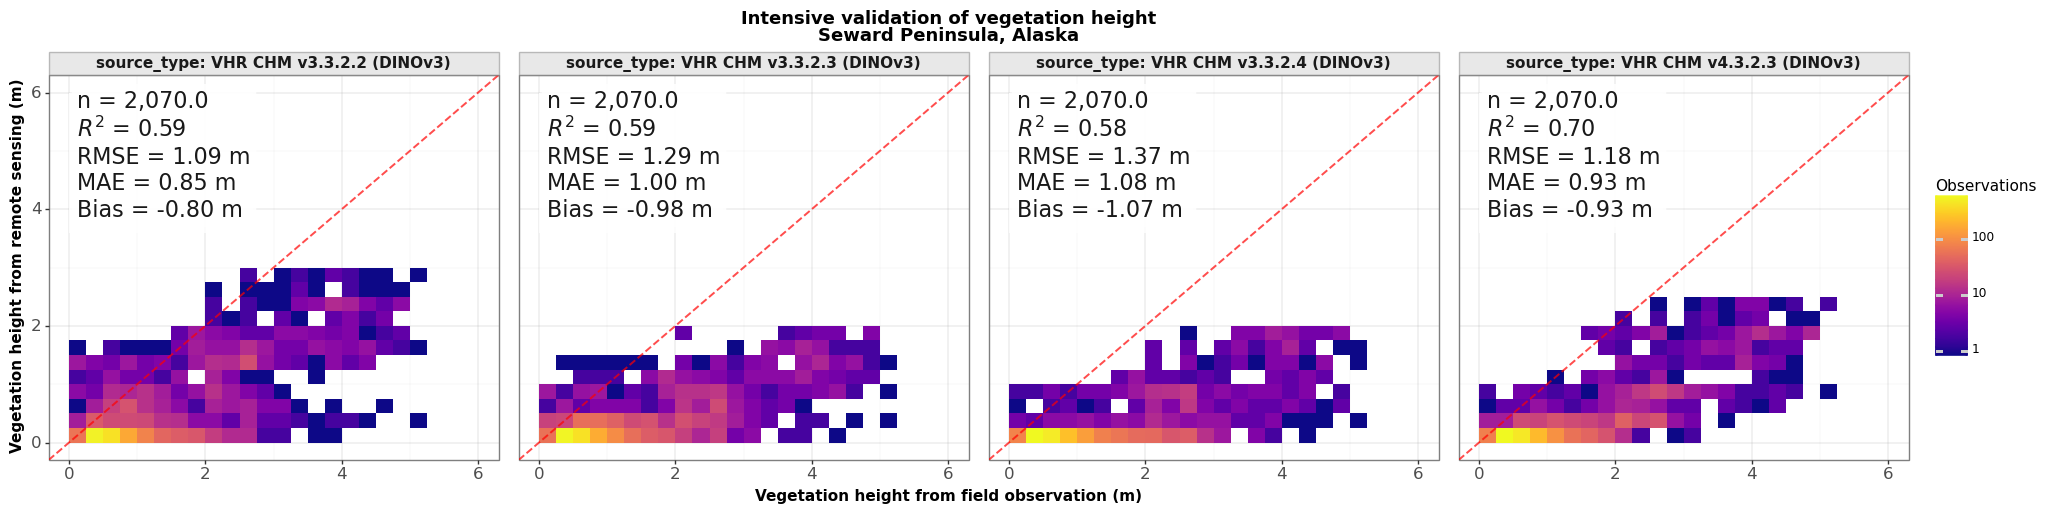

In [25]:
# Example 4: facet_wrap with new attributes
plot, stats = run_validation_analysis(
    all_ref_m, PLOT_CONFIG, FILTER_CONFIG,
    plot_type='grid',
    facet_wrap_vars=['loss_function', 'training_size', 'source_type']
)
print(plot)
# # Example 5: Save to file
# plot, stats = run_validation_analysis(
#     all_ref_m,
#     output_dir='./plots',
#     plot_type='grid',
#     facet_row_vars=['loss_function'],
#     facet_col_vars=['training_size']
# )